In [58]:
# Install packages - run this once
%pip install nltk scikit-learn pandas numpy matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


In [59]:
# Spacy not needed for this project - skipping download
print("Packages ready!")

Packages ready!


In [60]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [61]:
aq_text_map = {
    "A1_Score": "my child avoids eye contact",
    "A2_Score": "my child shows repetitive behavior",
    "A3_Score": "my child has difficulty in social interaction",
    "A4_Score": "my child struggles to understand social cues",
    "A5_Score": "my child prefers to be alone",
    "A6_Score": "my child has delayed communication skills",
    "A7_Score": "my child repeats words or phrases",
    "A8_Score": "my child finds it hard to adapt to changes",
    "A9_Score": "my child has limited imaginative play",
    "A10_Score": "my child does not respond when called"
}

In [62]:
from scipy.io import arff

# Load the .arff file
data_arff, meta = arff.loadarff('Autism-Child-Data.arff')

# Convert to pandas DataFrame
df = pd.DataFrame(data_arff)

# Decode byte string columns to UTF-8 strings
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

print("DataFrame loaded and byte strings decoded successfully. First 5 rows:")
print(df.head())

DataFrame loaded and byte strings decoded successfully. First 5 rows:
  A1_Score A2_Score A3_Score A4_Score A5_Score A6_Score A7_Score A8_Score  \
0        1        1        0        0        1        1        0        1   
1        1        1        0        0        1        1        0        1   
2        1        1        0        0        0        1        1        1   
3        0        1        0        0        1        1        0        0   
4        1        1        1        1        1        1        1        1   

  A9_Score A10_Score  ...  gender        ethnicity jundice austim  \
0        0         0  ...       m           Others      no     no   
1        0         0  ...       m  Middle Eastern       no     no   
2        0         0  ...       m                ?      no     no   
3        0         1  ...       f                ?     yes     no   
4        1         1  ...       m           Others     yes     no   

   contry_of_res used_app_before result    age_desc 

In [63]:
aq_score_cols = [f'A{i}_Score' for i in range(1, 11)]
df[aq_score_cols] = df[aq_score_cols].astype(int)

print("Data types of A_Score columns after conversion:")
print(df[aq_score_cols].dtypes)

Data types of A_Score columns after conversion:
A1_Score     int32
A2_Score     int32
A3_Score     int32
A4_Score     int32
A5_Score     int32
A6_Score     int32
A7_Score     int32
A8_Score     int32
A9_Score     int32
A10_Score    int32
dtype: object


In [64]:
parent_dialogues = []

for index, row in df.iterrows():
    current_dialogue_parts = []
    for col_name in aq_score_cols:
        if row[col_name] == 1:
            current_dialogue_parts.append(aq_text_map[col_name])
    parent_dialogues.append(". ".join(current_dialogue_parts))

df['parent_dialogue'] = parent_dialogues

print("DataFrame with 'parent_dialogue' column added. First 5 rows:")
print(df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'parent_dialogue']].head())

DataFrame with 'parent_dialogue' column added. First 5 rows:
   A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  \
0         1         1         0         0         1   
1         1         1         0         0         1   
2         1         1         0         0         0   
3         0         1         0         0         1   
4         1         1         1         1         1   

                                     parent_dialogue  
0  my child avoids eye contact. my child shows re...  
1  my child avoids eye contact. my child shows re...  
2  my child avoids eye contact. my child shows re...  
3  my child shows repetitive behavior. my child p...  
4  my child avoids eye contact. my child shows re...  


In [65]:
df_ml = df.rename(columns={"Class/ASD": "label"})
df_ml = df_ml[df_ml["parent_dialogue"].str.strip() != ""]

print("Child DataFrame shape:", df_ml.shape)

Child DataFrame shape: (291, 22)


In [66]:
from scipy.io import arff

# Load the .arff file
data_adolescent_arff, meta_adolescent = arff.loadarff('Autism-Adolescent-Data.arff')

# Convert to pandas DataFrame
df_adolescent = pd.DataFrame(data_adolescent_arff)

# Decode byte string columns to UTF-8 strings
for column in df_adolescent.columns:
    if df_adolescent[column].dtype == 'object':
        df_adolescent[column] = df_adolescent[column].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

print("DataFrame loaded and byte strings decoded successfully. First 5 rows:")
print(df_adolescent.head())

DataFrame loaded and byte strings decoded successfully. First 5 rows:
  A1_Score A2_Score A3_Score A4_Score A5_Score A6_Score A7_Score A8_Score  \
0        0        0        0        1        1        1        1        1   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        1        1        1        1        1        0        1   
4        1        1        1        1        1        1        1        0   

  A9_Score A10_Score  ...  gender       ethnicity jundice austim  \
0        1         0  ...       m        Hispanic     yes    yes   
1        1         1  ...       m           Black      no     no   
2        1         1  ...       f               ?      no     no   
3        1         0  ...       f  White-European      no     no   
4        0         0  ...       f               ?      no     no   

    contry_of_res used_app_before result     age_desc  rel

In [67]:
aq_score_cols = [f'A{i}_Score' for i in range(1, 11)]
df_adolescent[aq_score_cols] = df_adolescent[aq_score_cols].astype(int)

adolescent_dialogues = []

for index, row in df_adolescent.iterrows():
    current_dialogue_parts = []
    for col_name in aq_score_cols:
        if row[col_name] == 1:
            current_dialogue_parts.append(aq_text_map[col_name])
    adolescent_dialogues.append(". ".join(current_dialogue_parts))

df_adolescent['parent_dialogue'] = adolescent_dialogues

df_adolescent = df_adolescent.rename(columns={"Class/ASD": "label"})
df_adolescent['label'] = df_adolescent['label'].map({'YES': 1, 'NO': 0})

df_adolescent = df_adolescent[df_adolescent["parent_dialogue"].str.strip() != ""]

print("Processed df_adolescent DataFrame. First 5 rows:")
print(df_adolescent[['parent_dialogue', 'label']].head())

Processed df_adolescent DataFrame. First 5 rows:
                                     parent_dialogue  label
0  my child struggles to understand social cues. ...      0
1  my child has limited imaginative play. my chil...      0
2  my child has limited imaginative play. my chil...      0
3  my child shows repetitive behavior. my child h...      1
4  my child avoids eye contact. my child shows re...      1


## Combine Datasets

### Subtask:
Concatenate the processed child DataFrame (`df_ml`) and the newly processed adolescent DataFrame into a single combined DataFrame.


**Reasoning**:
To combine the processed child and adolescent dataframes, I will use `pd.concat` to vertically stack `df_ml` and `df_adolescent` and then reset the index of the resulting combined dataframe.



In [68]:
df_combined = pd.concat([df_ml, df_adolescent], ignore_index=True)

print("Combined DataFrame created. First 5 rows:")
print(df_combined.head())
print("\nShape of combined DataFrame:", df_combined.shape)

Combined DataFrame created. First 5 rows:
   A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0         1         1         0         0         1         1         0   
1         1         1         0         0         1         1         0   
2         1         1         0         0         0         1         1   
3         0         1         0         0         1         1         0   
4         1         1         1         1         1         1         1   

   A8_Score  A9_Score  A10_Score  ...        ethnicity jundice austim  \
0         1         0          0  ...           Others      no     no   
1         1         0          0  ...  Middle Eastern       no     no   
2         1         0          0  ...                ?      no     no   
3         0         0          1  ...                ?     yes     no   
4         1         1          1  ...           Others     yes     no   

   contry_of_res used_app_before result    age_desc  relation label 

## Prepare Combined Data for ML

### Subtask:
Extract the 'parent_dialogue' as X_text and 'label' as y from the combined DataFrame, then perform TF-IDF vectorization on X_text, and finally split the data into training and testing sets (X_train, X_test, y_train, y_test).


**Reasoning**:
I will extract the 'parent_dialogue' and 'label' columns, perform TF-IDF vectorization on the 'parent_dialogue', and then split the data into training and testing sets as per the instructions.



In [69]:
X_text = df_combined["parent_dialogue"]
y = df_combined["label"].map({'YES': 1, 'NO': 0, 1: 1, 0: 0}).astype(int)

vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2)
)
X = vectorizer.fit_transform(X_text)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data preparation complete.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Data preparation complete.
X_train shape: (316, 92), y_train shape: (316,)
X_test shape: (79, 92), y_test shape: (79,)


In [70]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# LinearSVC Model
print("Training LinearSVC Model...")
svm = LinearSVC(random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("LinearSVC Accuracy:", accuracy_score(y_test, y_pred_svm)*100)
print(classification_report(y_test, y_pred_svm))

# Logistic Regression Model
print("\nTraining Logistic Regression Model...")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, pred_lr)*100)
print(classification_report(y_test, pred_lr))

# KNeighborsClassifier Model
print("\nTraining KNeighborsClassifier Model...")
knn = KNeighborsClassifier(n_neighbors=5, metric="cosine")
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, pred_knn)*100)
print(classification_report(y_test, pred_knn))

# RandomForestClassifier Model
print("\nTraining RandomForestClassifier Model...")
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, pred_rf)*100)
print(classification_report(y_test, pred_rf))

Training LinearSVC Model...
LinearSVC Accuracy: 91.13924050632912
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        38
           1       0.85      1.00      0.92        41

    accuracy                           0.91        79
   macro avg       0.93      0.91      0.91        79
weighted avg       0.92      0.91      0.91        79


Training Logistic Regression Model...
Logistic Regression Accuracy: 84.81012658227847
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        38
           1       0.80      0.95      0.87        41

    accuracy                           0.85        79
   macro avg       0.86      0.84      0.85        79
weighted avg       0.86      0.85      0.85        79


Training KNeighborsClassifier Model...
KNN Accuracy: 81.0126582278481
              precision    recall  f1-score   support

           0       0.93      0.66      0.77        38
           1 

c:\Users\abhik\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Random Forest Accuracy: 100.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        41

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79



## Model Evaluation Visualizations

This section provides visual and tabular summaries of model performance, including confusion matrices, a summary table of classification metrics, and feature importance plots for tree-based models.

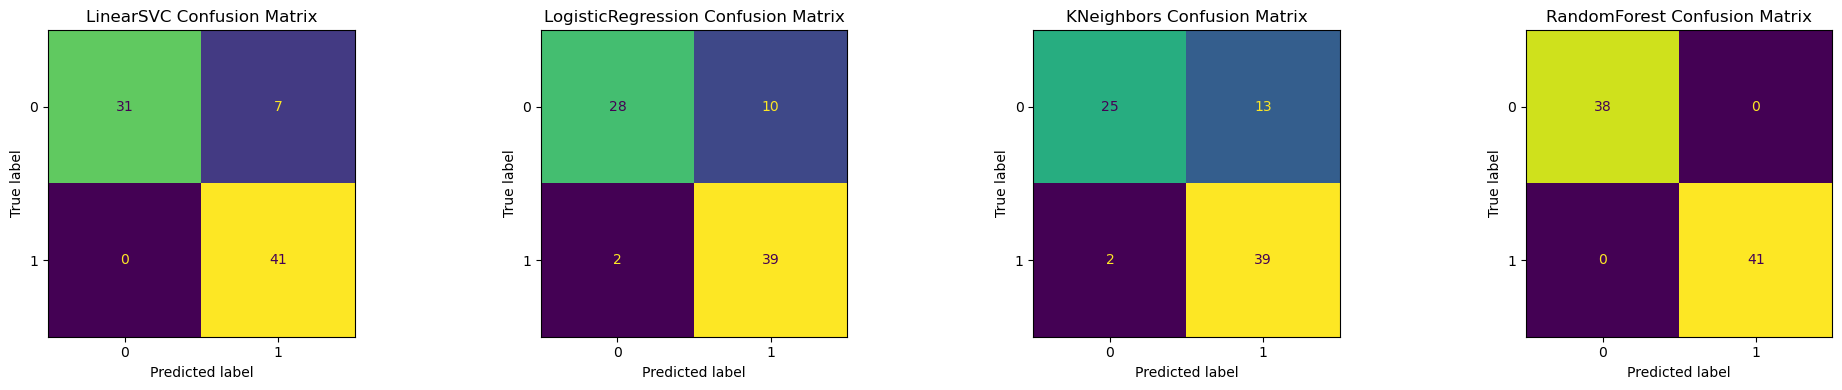

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import pandas as pd

models = {
    'LinearSVC': svm,
    'LogisticRegression': lr,
    'KNeighbors': knn,
    'RandomForest': rf
    # 'XGBoost': xgb  # Uncomment if XGBoost is used
}
predictions = {
    'LinearSVC': y_pred_svm,
    'LogisticRegression': pred_lr,
    'KNeighbors': pred_knn,
    'RandomForest': pred_rf
    # 'XGBoost': pred_xgb  # Uncomment if XGBoost is used
}

# 1. Confusion Matrices
fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))
if len(models) == 1:
    axes = [axes]
for ax, (name, pred) in zip(axes, predictions.items()):
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f'{name} Confusion Matrix')
plt.tight_layout()
plt.show()

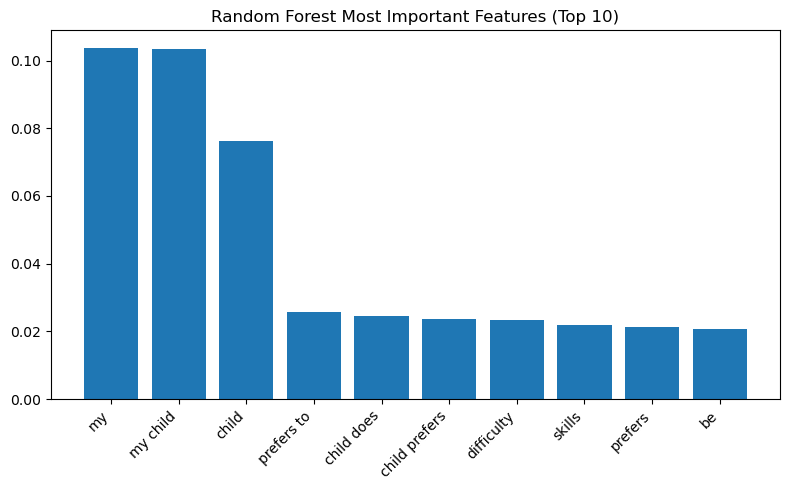

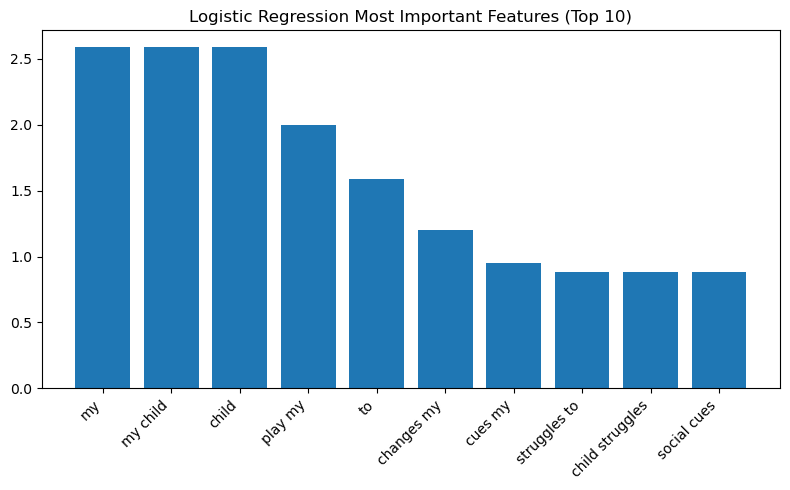

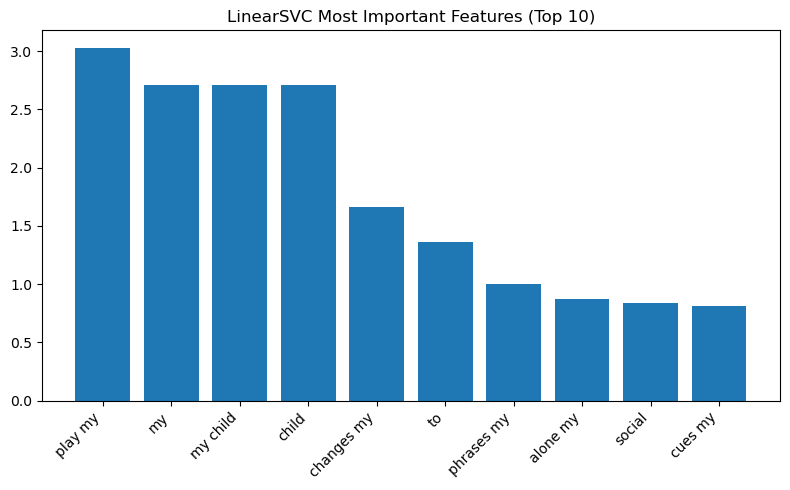

In [72]:
# 4. Feature Importance/Weights for All Models
importances_dict = {}
feature_names = vectorizer.get_feature_names_out()

# Random Forest
if hasattr(rf, 'feature_importances_'):
    importances_dict['Random Forest'] = rf.feature_importances_
# Logistic Regression
if hasattr(lr, 'coef_'):
    importances_dict['Logistic Regression'] = lr.coef_[0]
# LinearSVC
if hasattr(svm, 'coef_'):
    importances_dict['LinearSVC'] = svm.coef_[0]

# Plotting
for model_name, importances in importances_dict.items():
    indices = np.argsort(np.abs(importances))[::-1][:10]  # Top 10 by absolute value
    plt.figure(figsize=(8, 5))
    plt.title(f'{model_name} Most Important Features (Top 10)')
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [73]:
# 5. K-Fold Cross-Validation for All Models
from sklearn.model_selection import cross_validate, StratifiedKFold

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)
    cv_results[name] = {metric: scores[f'test_{metric}'] for metric in scoring}
    print(f"\n{name} Cross-Validation Results:")
    for metric in scoring:
        print(f"  {metric}: {scores[f'test_{metric}'].mean():.4f} ± {scores[f'test_{metric}'].std():.4f}")


c:\Users\abhik\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\abhik\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\abhik\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\abhik\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\abhik\anaconda3\Lib\site-packages\sklearn\svm\_clas


LinearSVC Cross-Validation Results:
  accuracy: 0.9139 ± 0.0148
  precision_macro: 0.9272 ± 0.0130
  recall_macro: 0.9111 ± 0.0148
  f1_macro: 0.9127 ± 0.0151

LogisticRegression Cross-Validation Results:
  accuracy: 0.8456 ± 0.0203
  precision_macro: 0.8600 ± 0.0225
  recall_macro: 0.8426 ± 0.0206
  f1_macro: 0.8431 ± 0.0207

KNeighbors Cross-Validation Results:
  accuracy: 0.8228 ± 0.0266
  precision_macro: 0.8619 ± 0.0168
  recall_macro: 0.8174 ± 0.0285
  f1_macro: 0.8155 ± 0.0303

RandomForest Cross-Validation Results:
  accuracy: 1.0000 ± 0.0000
  precision_macro: 1.0000 ± 0.0000
  recall_macro: 1.0000 ± 0.0000
  f1_macro: 1.0000 ± 0.0000


In [74]:
# 6. Summary Table for Cross-Validation Results
summary_df = pd.DataFrame({
    model: {metric: cv_results[model][metric].mean() for metric in cv_results[model]} for model in cv_results
}).T
summary_df = summary_df.rename_axis('Model').reset_index()

print("\nCross-Validation Mean Scores Summary:")
display(summary_df)

# Feature importance plots (already present in previous cell for models that support it)



Cross-Validation Mean Scores Summary:


,Model,accuracy,precision_macro,recall_macro,f1_macro
0,LinearSVC,0.913924,0.927207,0.911130,0.912744
1,LogisticRegression,0.845570,0.859969,0.842591,0.843054
2,KNeighbors,0.822785,0.861897,0.817369,0.815473
3,RandomForest,1.000000,1.000000,1.000000,1.000000


In [75]:
# 7. Create comparison DataFrame (Test Set vs Cross-Validation Metrics)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Gather test set metrics for each model
test_metrics = {}
test_predictions = {
    'LinearSVC': y_pred_svm,
    'LogisticRegression': pred_lr,
    'KNeighbors': pred_knn,
    'RandomForest': pred_rf
}
for name, pred in test_predictions.items():
    test_metrics[name] = {
        'accuracy': accuracy_score(y_test, pred),
        'precision_macro': precision_score(y_test, pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test, pred, average='macro', zero_division=0)
    }
test_df = pd.DataFrame(test_metrics).T.reset_index().rename(columns={'index': 'Model'})

# Merge with cross-validation summary
compare_df = pd.merge(test_df, summary_df, on='Model', suffixes=('_test', '_cv'))

print("\nComparison of Test Set vs Cross-Validation Metrics:")
display(compare_df)


Comparison of Test Set vs Cross-Validation Metrics:


,Model,accuracy_test,precision_macro_test,recall_macro_test,f1_macro_test,accuracy_cv,precision_macro_cv,recall_macro_cv,f1_macro_cv
0,LinearSVC,0.911392,0.927083,0.907895,0.909950,0.913924,0.927207,0.911130,0.912744
1,LogisticRegression,0.848101,0.864626,0.844031,0.845098,0.845570,0.859969,0.842591,0.843054
2,KNeighbors,0.810127,0.837963,0.804557,0.803970,0.822785,0.861897,0.817369,0.815473
3,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [76]:
# 8. Table: Test Set vs Cross-Validation Metrics and Differences (Accuracy in %)

# Prepare a summary table with differences
metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
diff_df = compare_df[['Model']].copy()
for metric in metrics:
    if metric == 'accuracy':
        # Show accuracy as percentage
        diff_df[f'{metric}_test'] = compare_df[f'{metric}_test'] * 100
        diff_df[f'{metric}_cv'] = compare_df[f'{metric}_cv'] * 100
        diff_df[f'{metric}_diff'] = (compare_df[f'{metric}_test'] - compare_df[f'{metric}_cv']) * 100
    else:
        diff_df[f'{metric}_test'] = compare_df[f'{metric}_test']
        diff_df[f'{metric}_cv'] = compare_df[f'{metric}_cv']
        diff_df[f'{metric}_diff'] = compare_df[f'{metric}_test'] - compare_df[f'{metric}_cv']

# Reorder columns for clarity
cols = ['Model']
for metric in metrics:
    cols += [f'{metric}_test', f'{metric}_cv', f'{metric}_diff']
diff_df = diff_df[cols]

print("\nTable: Test Set vs Cross-Validation Metrics and Differences (Accuracy in %)")
display(diff_df)



Table: Test Set vs Cross-Validation Metrics and Differences (Accuracy in %)


,Model,accuracy_test,accuracy_cv,accuracy_diff,precision_macro_test,precision_macro_cv,precision_macro_diff,recall_macro_test,recall_macro_cv,recall_macro_diff,f1_macro_test,f1_macro_cv,f1_macro_diff
0,LinearSVC,91.139241,91.392405,-0.253165,0.927083,0.927207,-0.000124,0.907895,0.911130,-0.003235,0.909950,0.912744,-0.002794
1,LogisticRegression,84.810127,84.556962,0.253165,0.864626,0.859969,0.004657,0.844031,0.842591,0.001440,0.845098,0.843054,0.002044
2,KNeighbors,81.012658,82.278481,-1.265823,0.837963,0.861897,-0.023934,0.804557,0.817369,-0.012812,0.803970,0.815473,-0.011503
3,RandomForest,100.000000,100.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
